In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
counts = {
    'B_CD8T': 474521,
    'B_T': 1435388,
    'PBMC_all': 2238732,
    'TCells': 1280445,
    'PBMC5K': 72208619,
    'Chen': 22331703,
    'Camp': 2762889,
    'HLCA_aorta': 1026532,
    'HLCA_lung': 4317000,
    'HLCA_marrow': 15854124,
    'CellLines': 5516980,
    'HSC': 13634167,
    'FibrocardRNA': 50000000,
    'FibrocardATAC': 138840495, 
}

In [3]:
def get_category(x):
    return f'{x["method"]}{x["dataset"]}{x["metric"]}'

def get_category_lookup(x):
    return f'dense_GPU{x["dataset"]}{x["metric"]}'

def vlookup(df, x):
    return df.set_index('cated').loc[x['vlookup_cated'], 'mean']

In [49]:
def get_input_data(from_range, to_range):

    outputs = []

    for dataset in [
        'B_T', 'B_CD8T', 'PBMC_all', 'TCells', 'PBMC5K', 'Chen', 'Camp', 'HSC', 'HLCA_aorta', 'HLCA_lung', 'HLCA_marrow', 'CellLines',
        'FibrocardRNA', 'FibrocardATAC'
    ]:
        for method in ['dense_amap', 'dense_factoextra', 'dense_CPU', 'dense_GPU', 'sparse_CPU', 'sparse_GPU', 'dense_pythonic', 'dense_pandas']:
            metric = 'kendall'
            filename = f'../results/RealDatasets/{dataset}/{method}_{metric}.csv'
#             print(filename)
            if not os.path.exists(filename):
                if method == 'dense_pythonic':
                    method_new = 'scipy'
                else:
                    method_new = method
                output = {
                    'metric': metric,
                    'dataset': dataset,
                    'mean': 10 ** 11,
                    'method': method_new,
                    'missing': True
                }
            else:
                df = pd.read_csv(filename)
                values = df.loc[from_range:to_range, df.columns[0]]

                if len(values) == 0:
                    values = df.loc[df.shape[0] - 1, df.columns[0]]

                mean_value = values[values > 0].mean()
                if method == 'dense_pythonic':
                    method_new = 'scipy'
                    mean_value *= 24
                else:
                    method_new = method

                output = {
                    'metric': metric,
                    'dataset': dataset,
                    'mean': mean_value,
                    'log_mean': np.log10(mean_value),
                    'method': method_new,
                    'missing': False,
                }

            outputs.append(output)
    df_updated = pd.DataFrame(outputs)
    df_updated['cated'] = df_updated.apply(get_category, axis=1)
    df_updated['vlookup_cated'] = df_updated.apply(get_category_lookup, axis=1)
    
    df_updated['base'] = df_updated.apply(lambda x: vlookup(df_updated, x), axis=1)
    df_updated['acceleration'] = df_updated['base'] / df_updated['mean']
    df_updated.loc[df_updated.method == 'scipy', 'method'] = 'scipy'
    df_updated.loc[df_updated.method == 'dense_pandas', 'method'] = 'pandas'
    df_updated.loc[df_updated.method == 'dense_CPU', 'method'] = 'CPU'
    df_updated.loc[df_updated.method == 'dense_factoextra', 'method'] = 'factoextra'
    df_updated.loc[df_updated.method == 'dense_amap', 'method'] = 'amap'
    df_updated.loc[df_updated.method == 'dense_raft', 'method'] = 'raft-dense'
    df_updated.loc[df_updated.method == 'sparse_raft', 'method'] = 'raft-sparse'
    df_updated.loc[df_updated['method'] == 'CPU', 'method'] = 'GADES-CPU-dense'
    df_updated.loc[df_updated['method'] == 'dense_GPU', 'method'] = 'GADES-GPU-dense'
    df_updated.loc[df_updated['method'] == 'sparse_GPU', 'method'] = 'GADES-GPU-sparse'
    df_updated.loc[df_updated['method'] == 'sparse_CPU', 'method'] = 'GADES-CPU-sparse'
    df_updated.loc[df_updated['method'] == 'dense_raft', 'method'] = 'raft'
    df_updated['log_acceleration'] = df_updated.acceleration.apply(lambda x: np.log10(x))
    return df_updated

In [50]:
all_df = get_input_data(0, 1)

In [51]:
all_df_sequential = get_input_data(0, 100)

In [52]:
import seaborn as sns

In [53]:
df_missing_counts = all_df[all_df.missing].groupby(['metric', 'method']).count()

In [54]:
missing_pivot = df_missing_counts.reset_index().pivot(index='metric', columns='method', values='dataset')
missing_pivot = missing_pivot.fillna(0.1)

In [57]:
df_missing_unmelt = pd.melt(missing_pivot, ignore_index=False).reset_index()

In [58]:
remapping = {
    'dense_CPU': 'GADES-CPU-dense',
    'sparse_CPU': 'GADES-CPU-sparse',
    'dense_GPU': 'GADES-GPU-dense',
    'sparse_GPU': 'GADES-GPU-sparse',
    'dense_amap': 'amap',
    'scipy': 'scipy',
    'dense_pandas': 'pandas',
    'dense_factoextra': 'factoextra',
}

# Acceleration Load

In [59]:
import matplotlib.pyplot as plt

df_test = all_df.copy()

df_test.loc[df_test.missing, 'log_mean'] = 0.1

In [60]:
methods = ['amap', 'factoextra', 'scipy', 'pandas', 'GADES-CPU-dense', 'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse']

In [61]:
df_all_melt = df_missing_unmelt.copy()

In [62]:
df_all_melt['value'] = 14

In [63]:
df_all_melt['metric'] = '_' + df_all_melt['metric']

In [64]:
palette = sns.palettes.color_palette()[:len(methods)]
color_palette = {
    method: pallete for method, pallete in zip(methods, palette)
}

# Figure 5

In [65]:
all_df['method'].unique()

array(['amap', 'factoextra', 'GADES-CPU-dense', 'GADES-GPU-dense',
       'GADES-CPU-sparse', 'GADES-GPU-sparse', 'scipy', 'pandas'],
      dtype=object)

In [66]:
color_palette['GADES-GPU-dense'] = color_palette['GADES-GPU-dense']

In [67]:
methods = ['amap', 'factoextra', 'scipy', 'pandas', 'GADES-CPU-dense', 'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse']

In [68]:
def redraw_hatches_and_colors(ax):
    rectangles = [p for p in ax.patches if isinstance(p, Rectangle)]
    
    for rectangle in rectangles:
        rectangle.set_facecolor('gray')
        rectangle.set_alpha(0.5)

In [69]:
df_missing_unmelt['method'].unique()

array(['GADES-CPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-dense',
       'GADES-GPU-sparse', 'amap', 'factoextra', 'pandas', 'scipy'],
      dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes.ArtistList of 8 patches>


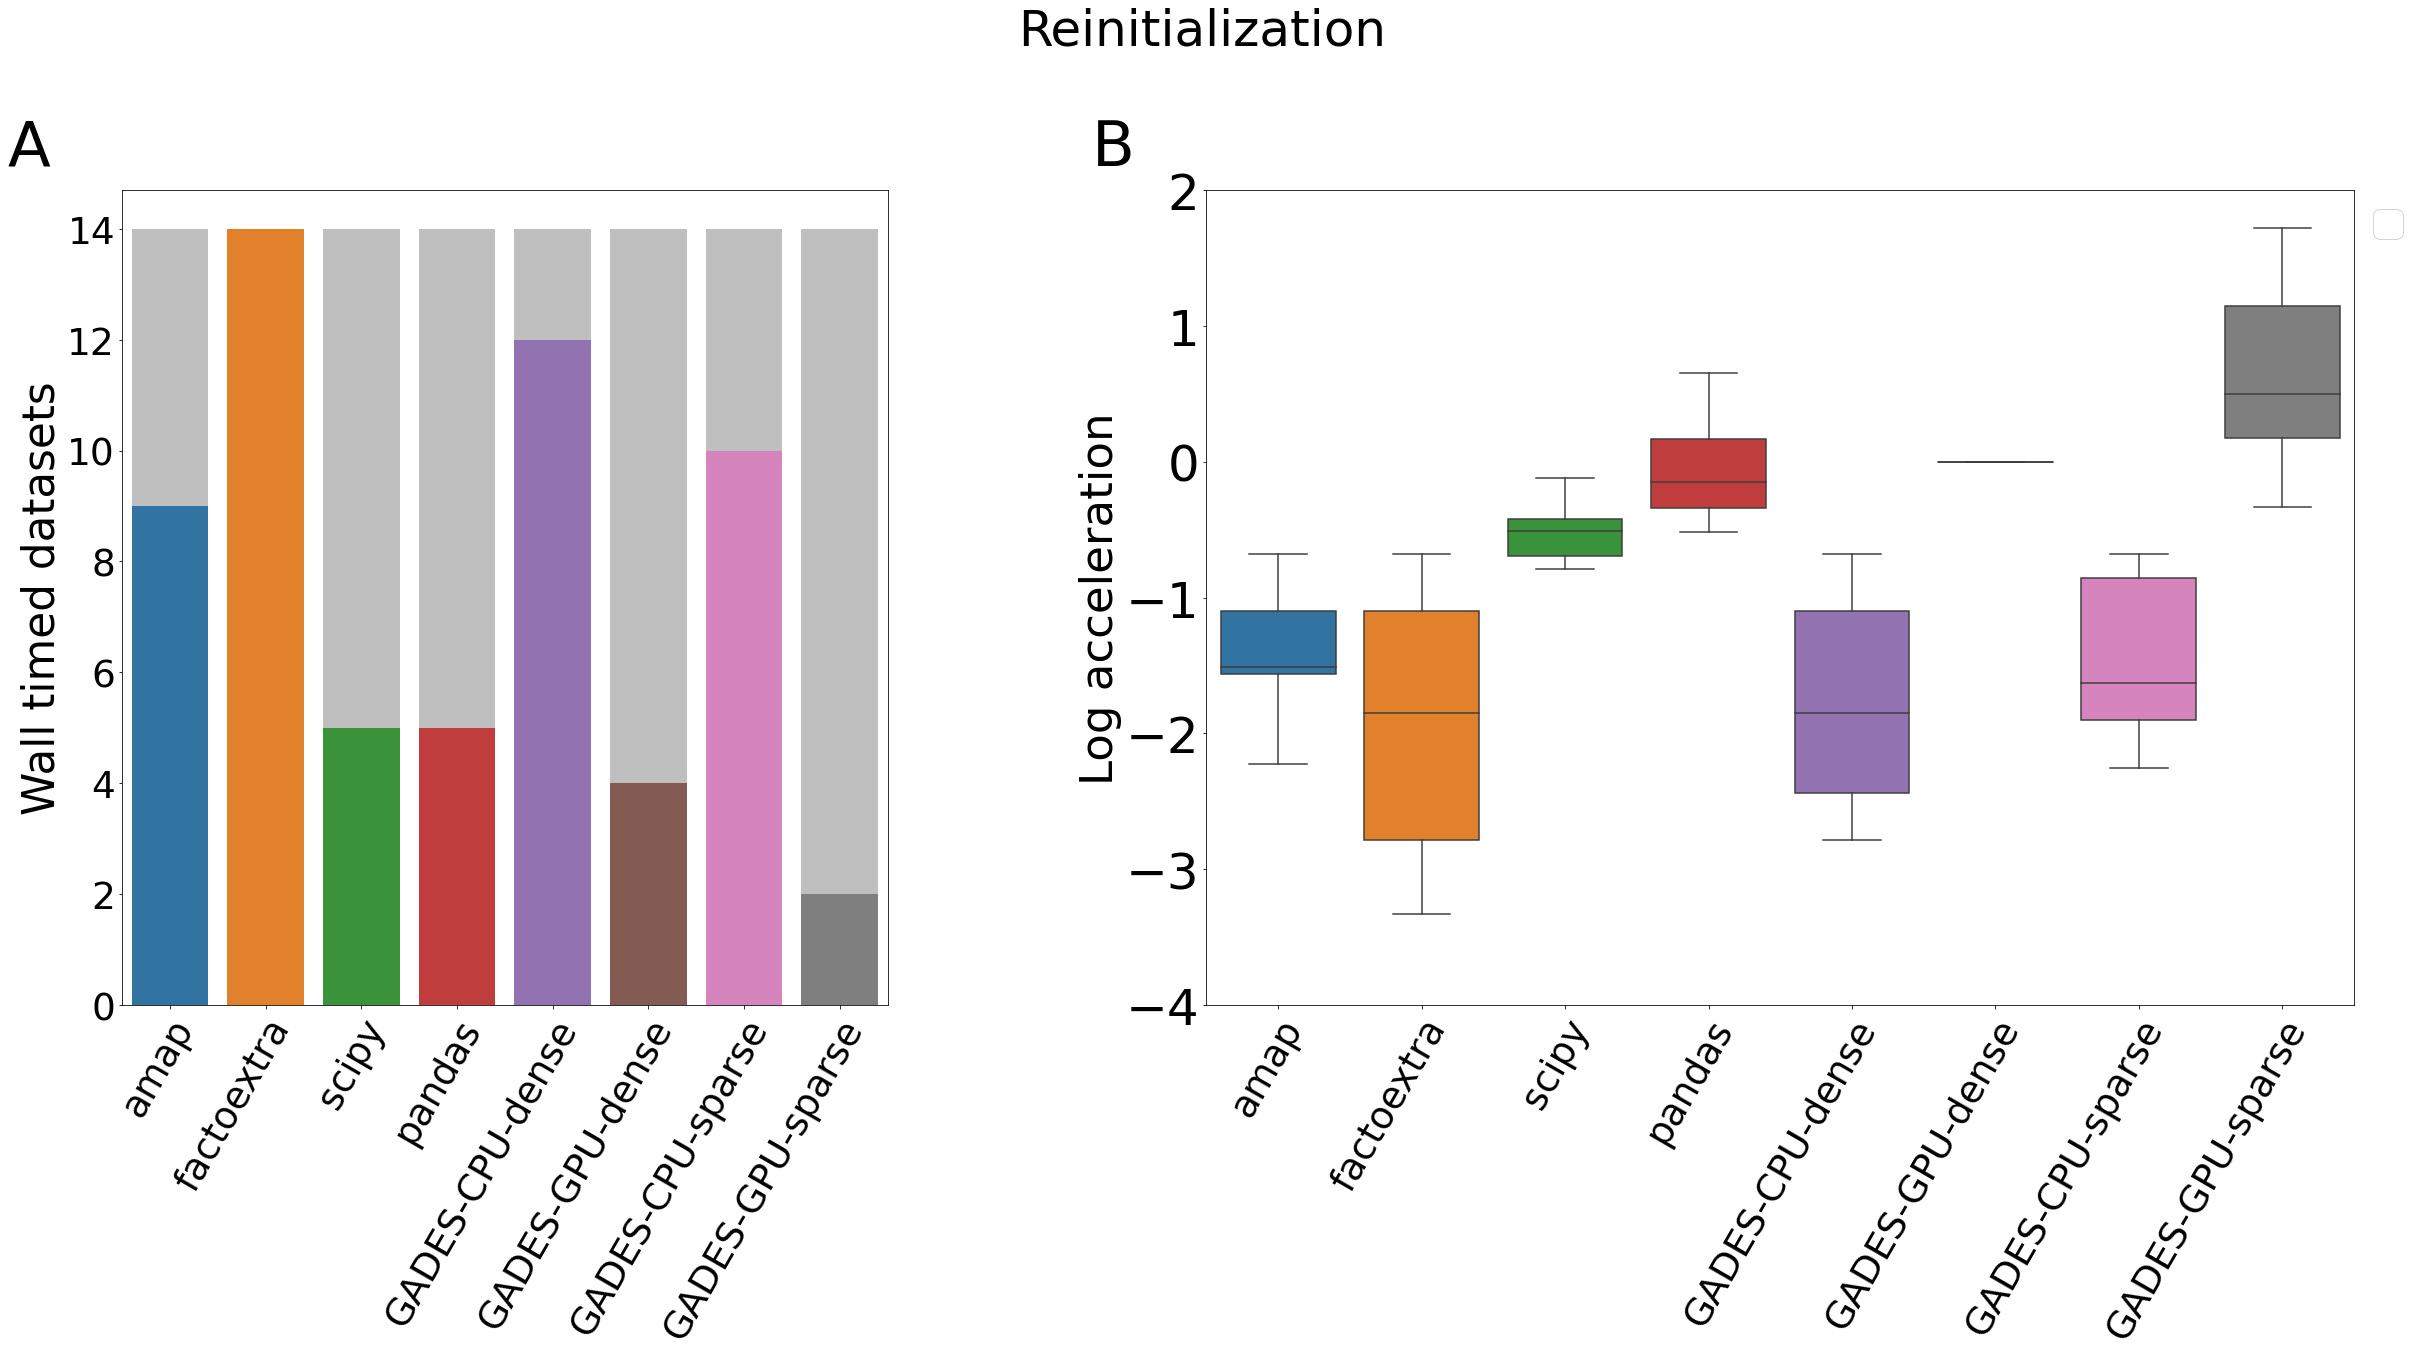

In [70]:
from matplotlib.gridspec import GridSpec

from matplotlib.patches import PathPatch, Rectangle
fig = plt.figure(figsize=(40, 15))

gs = GridSpec(1, 4, figure=fig, width_ratios=[1.5, 0.333, 0.333, 0.333]
             )

BASE_FONT_SIZE = 25
SCALE = 1.7

FONT_SIZE = BASE_FONT_SIZE * SCALE

current_ax = fig.add_subplot(gs[0])

plot = sns.barplot(
    ax=current_ax,
    data=df_all_melt, hue='metric', y='value', x='method',
    order=methods,
    hue_order=['_kendall'],
    zorder=0,
)
print(current_ax.patches)
plot.get_legend().remove()
redraw_hatches_and_colors(current_ax)

plot = sns.barplot(
    ax=current_ax,
    data=df_missing_unmelt[df_missing_unmelt['metric'] == 'kendall'],y='value', x='method',
    order=methods,
#     hue_order=['kendall'],
    palette=color_palette,
    zorder=2,
)


plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_ylabel(f'Wall timed datasets', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.15, 1.03, 'A', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
metric = 'kendall'

current_ax = fig.add_subplot(gs[1:])
plot = sns.boxplot(
    ax=current_ax,
    data=all_df[((all_df['method'] == 'GADES-GPU-dense') | (all_df.log_acceleration != 0)) & (all_df.metric == metric)], y='log_acceleration',
    x='method',
    order=[
        'amap',
        'factoextra',
        'scipy',
        'pandas',
        'GADES-CPU-dense',
        'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse'
    ],
)

plot.tick_params(labelsize=BASE_FONT_SIZE * 1.25)
current_ax.set_ylim(-4, 2)

plot.set_ylabel(f'Log acceleration', fontsize=BASE_FONT_SIZE * 1.8)
plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.1, 1.03, 'B', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=BASE_FONT_SIZE)
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 2)
current_ax.legend(fontsize=BASE_FONT_SIZE * 1.5, bbox_to_anchor=(1, 1))
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')

fig.suptitle('Reinitialization', size=BASE_FONT_SIZE * 2, y=1.05)
fig.subplots_adjust(wspace = 1.0)
fig.subplots_adjust(hspace=0.3)

plt.savefig(f'figure5.png', bbox_inches='tight', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes.ArtistList of 8 patches>


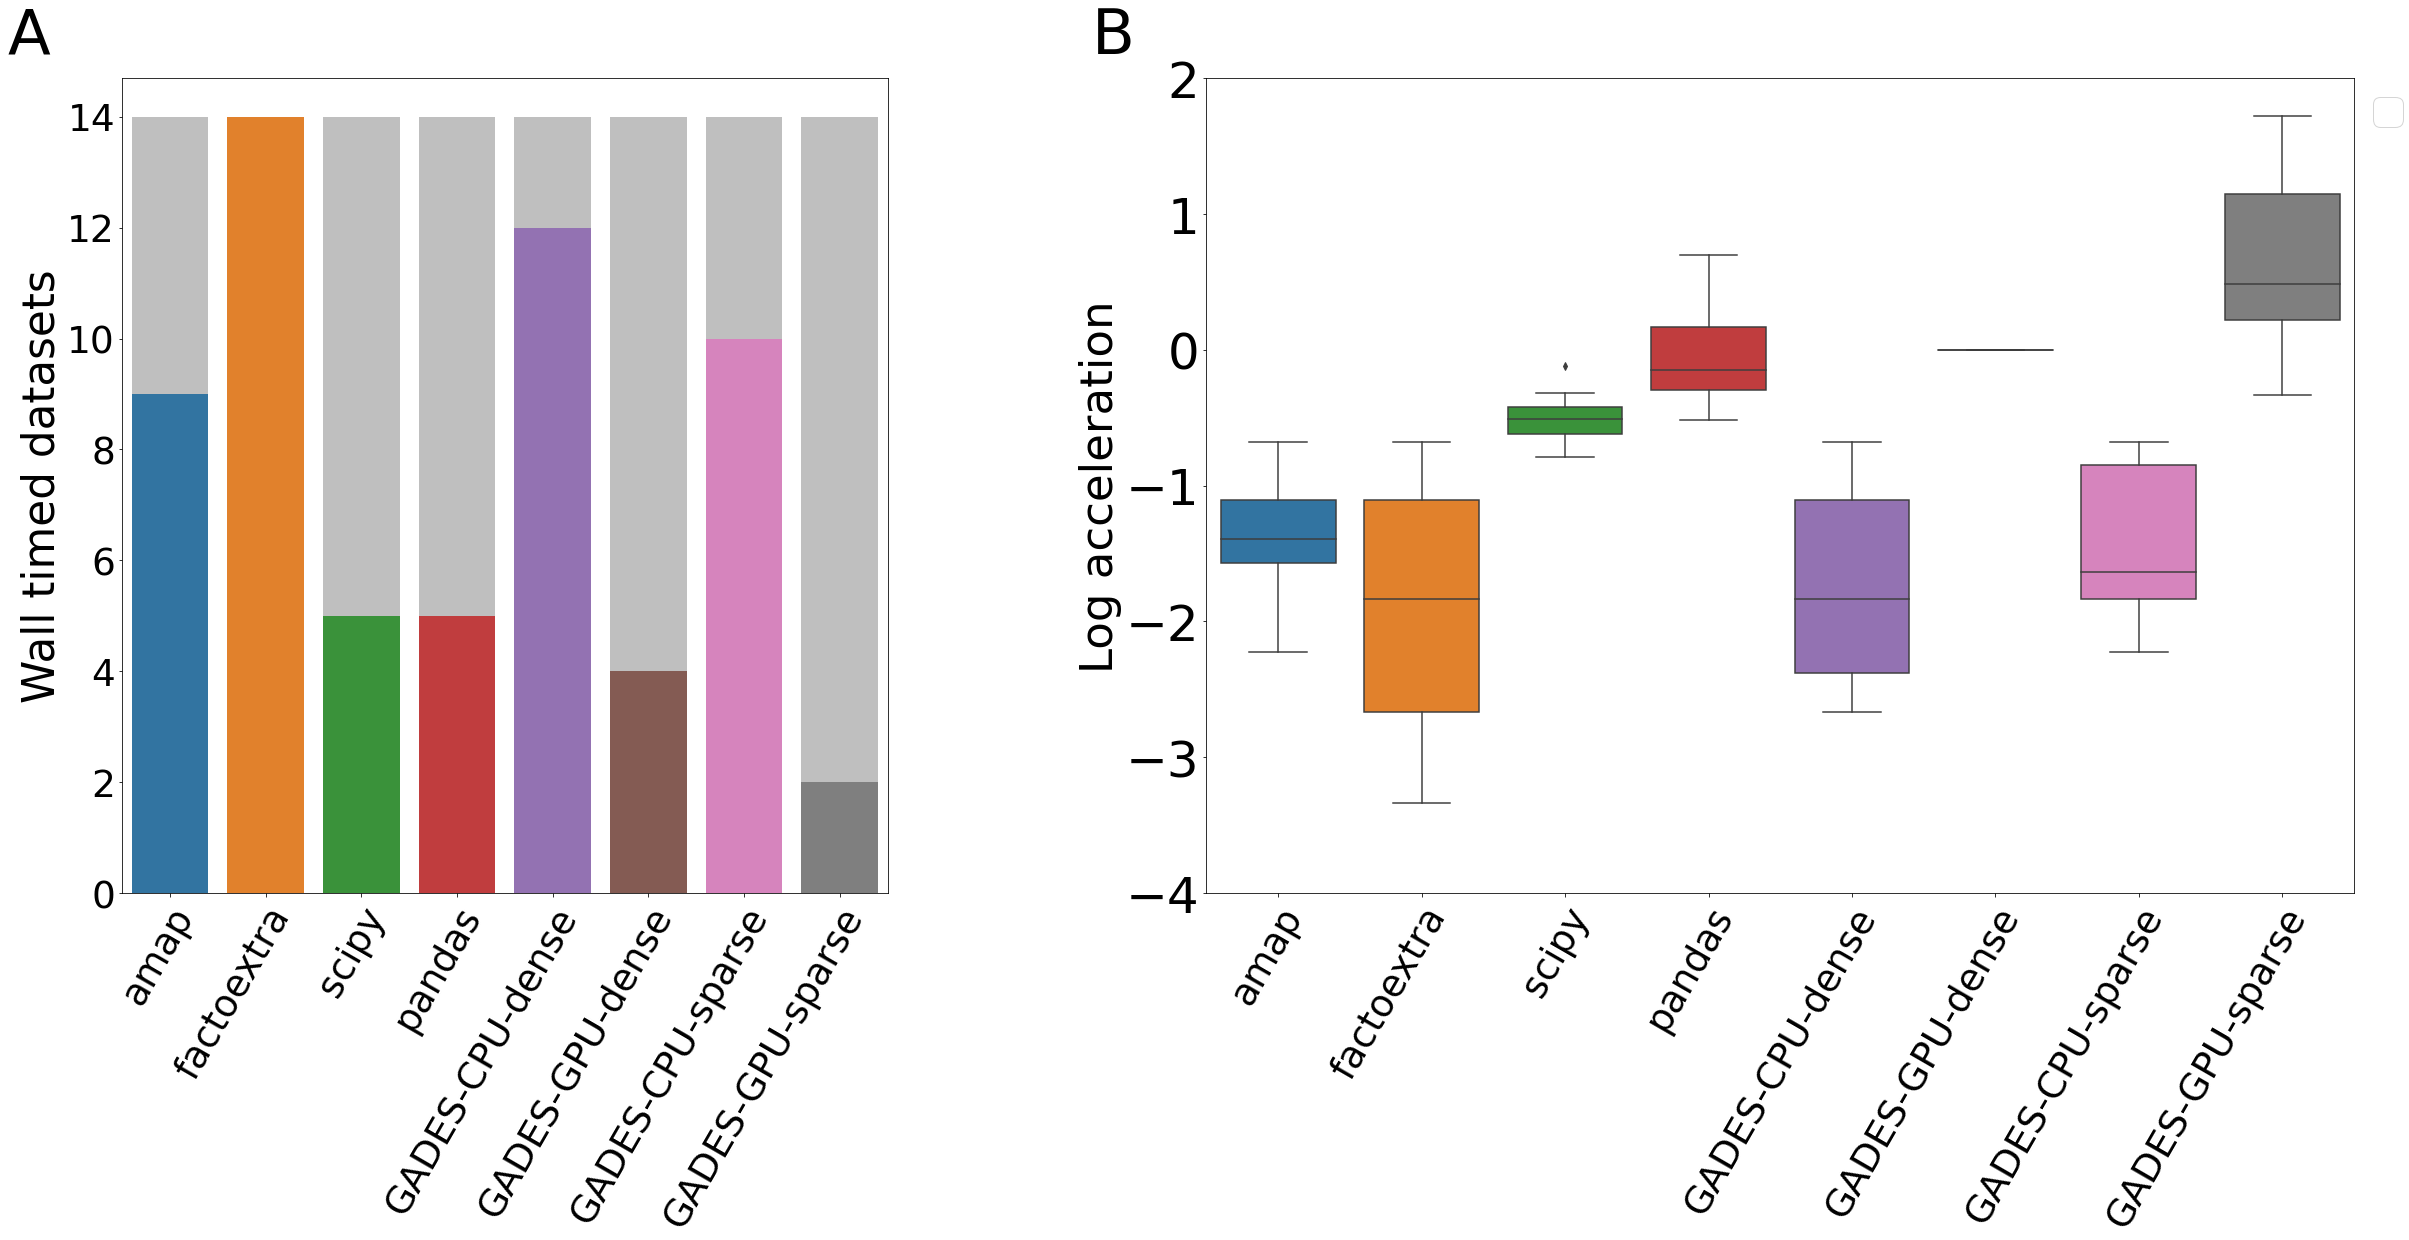

In [71]:
from matplotlib.gridspec import GridSpec

from matplotlib.patches import PathPatch, Rectangle
fig = plt.figure(figsize=(40, 15))

gs = GridSpec(1, 4, figure=fig, width_ratios=[1.5, 0.333, 0.333, 0.333]
             )

BASE_FONT_SIZE = 25
SCALE = 1.7

FONT_SIZE = BASE_FONT_SIZE * SCALE

current_ax = fig.add_subplot(gs[0])

plot = sns.barplot(
    ax=current_ax,
    data=df_all_melt, hue='metric', y='value', x='method',
    order=methods,
    hue_order=['_kendall'],
    zorder=0,
)
print(current_ax.patches)
plot.get_legend().remove()
redraw_hatches_and_colors(current_ax)


plot = sns.barplot(
    ax=current_ax,
    data=df_missing_unmelt[df_missing_unmelt['metric'] == 'kendall'],y='value', x='method',
    order=methods,
    palette=color_palette,
    zorder=2,
)


plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_ylabel(f'Wall timed datasets', fontsize=BASE_FONT_SIZE * 1.75)
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.15, 1.03, 'A', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)

metric = 'kendall'
current_ax = fig.add_subplot(gs[1:])
plot = sns.boxplot(
    ax=current_ax,
    data=all_df_sequential[((all_df_sequential['method'] == 'GADES-GPU-dense') | (all_df_sequential.log_acceleration != 0)) & (all_df_sequential.metric == metric)], y='log_acceleration',
    x='method',
    order=[
        'amap',
        'factoextra',
        'scipy',
        'pandas',
        'GADES-CPU-dense',
        'GADES-GPU-dense', 'GADES-CPU-sparse', 'GADES-GPU-sparse'
    ],
)

plot.tick_params(labelsize=BASE_FONT_SIZE * 1.25)
current_ax.set_ylim(-4, 2)

plot.set_ylabel(f'Log acceleration', fontsize=BASE_FONT_SIZE * 1.8)
plot.set_xlabel(f'', fontsize=BASE_FONT_SIZE * 1.5)
current_ax.text(-0.1, 1.03, 'B', fontdict={'size': BASE_FONT_SIZE * 2.5}, transform=current_ax.transAxes)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=BASE_FONT_SIZE)
current_ax.tick_params(labelsize=BASE_FONT_SIZE * 2)
current_ax.legend(fontsize=BASE_FONT_SIZE * 1.5, bbox_to_anchor=(1, 1))
plot.set_xticklabels(plot.get_xticklabels(), rotation=60, fontsize=BASE_FONT_SIZE * 1.5, ha='right', va='top', rotation_mode='anchor')


fig.subplots_adjust(wspace = 1.0)
fig.subplots_adjust(hspace=0.3)

plt.savefig(f'figure5-sequential.png', bbox_inches='tight', dpi=200)

In [72]:
all_df_sequential_2 = all_df_sequential[all_df_sequential.metric == 'kendall']

In [73]:
log_df_value = all_df_sequential_2[
    ~all_df_sequential_2.dataset.isin(['PBMC5K', 'FibrocardATAC'])
].groupby('method').mean()

In [201]:
log_df_value

,mean,log_mean,missing,base,acceleration,log_acceleration
method,,,,,,
GADES-CPU-dense,8.643301e+10,10.268160,0.833333,2.895220e+10,0.289985,-1.337312
GADES-CPU-sparse,7.107910e+10,9.902977,0.666667,2.895220e+10,0.303574,-1.093611
GADES-GPU-dense,2.895220e+10,9.054286,0.250000,2.895220e+10,1.000000,0.000000
GADES-GPU-sparse,7.249039e+09,8.949734,0.000000,2.895220e+10,9.499327,0.590980
amap,6.996456e+10,9.713247,0.666667,2.895220e+10,0.300351,-1.030368
factoextra,1.000000e+11,NaN,1.000000,2.895220e+10,0.289522,-1.459286
pandas,2.789629e+10,9.097194,0.250000,2.895220e+10,1.251158,-0.032181
raft-dense,1.000000e+11,NaN,1.000000,2.895220e+10,0.289522,-1.459286
raft-sparse,1.000000e+11,NaN,1.000000,2.895220e+10,0.289522,-1.459286
